In [128]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

from skimage.draw import line_aa

# summary info on models
from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [129]:
nImages  = 2000
imgSize = 30

# initialize tensor containing images
images = torch.zeros(nImages,1,imgSize,imgSize)
labels = torch.zeros(nImages)
classes = ["Horiz", "Vert"]

for i in range(nImages):

  noise = np.random.normal(loc=0, scale=1, size=(imgSize, imgSize))
 
  # add a random bar randomly
  i1 = np.random.choice(np.arange(2,25))
  i2 = np.random.choice(np.arange(2,4))
  if np.random.randn()>0:
    # horizontal
    noise[i1:i1+i2,] = 1
    labels[i] = 0
  else:
    # vertical
    noise[:,i1:i1+i2] = 1
    labels[i] = 1
  
  # add to the tensor
  images[i,:,:,:] = torch.Tensor(noise).view(1,imgSize,imgSize)

labels = labels[:,None]

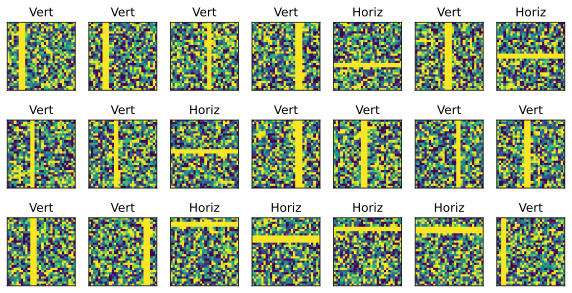

In [130]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(10,5))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(nImages)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1)
  ax.set_title(f'{classes[int(labels[whichpic].item())]}')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [131]:
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])



In [132]:
# check size (should be images X channels X width X height
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

torch.Size([1800, 1, 30, 30])
torch.Size([1800, 1])


In [133]:
# create a class for the model
def makeTheNet():

  class psychnet(nn.Module):
    def __init__(self):
      super().__init__()
      
      # all layers in one go using nn.Sequential
      self.enc = nn.Sequential(
          nn.Conv2d(1,10,3,padding=1), # output size: (30+2*1-3)/1 + 1 = 30
          nn.ReLU(),                   # note that relu is treated like a "layer"
          nn.AvgPool2d(2,2),           # output size: 30/2 = 15 
          nn.Conv2d(10,6,3,padding=1), # output size: (15+2*1-3)/1 + 1 = 15
          nn.ReLU(),                   # 
          nn.AvgPool2d(2,2),           # output size: 15/2 = 7
          nn.Flatten(),                # vectorize conv output
          nn.Linear(7*7*6,50),         # output size: 50
          nn.Linear(50,1),             # output size: 1
      )
      
    def forward(self,x):
      return self.enc(x)
  
  # create the model instance
  net = psychnet()
  
  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [134]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet()

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print(' ')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
torch.Size([32, 1])
 
Loss:
tensor(0.6953, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [135]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10
  
  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  testAcc   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      yHat = torch.sigmoid(yHat)

      # loss from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean(( (yHat>.5) == y).float()).item() )
    # end of batch loop...

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)
      
    # compare the following really long line of code to the training accuracy lines
    yHat = torch.sigmoid(yHat)
    testLoss[epochi] = loss.item()
    testAcc[epochi]  = 100*torch.mean(( (yHat>.5) == y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainAcc,testAcc,net

In [136]:
trainLoss,testLoss,trainAcc,testAcc,net = function2trainTheModel()

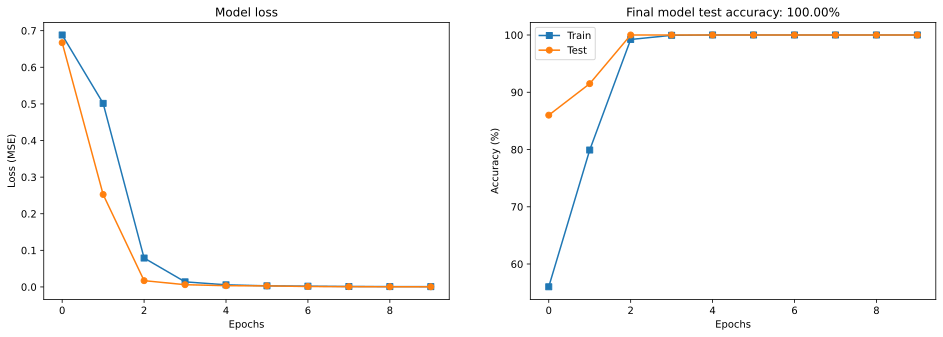

In [137]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [138]:
def add_random_line(image):
  # Generate random starting and ending points within image boundaries

  if np.random.randn()>0:
    x_start = 0
    y_start = np.random.randint(0, image.shape[0]-1)
    x_end = image.shape[0]-1
    y_end = np.random.randint(0, image.shape[0]-1)
  else:
    x_start = np.random.randint(0, image.shape[0]-1)
    y_start = 0
    x_end = np.random.randint(0, image.shape[1]-1)
    y_end = image.shape[1]-1

  # slope  
  if x_end == x_start:
    slope = np.inf  # Vertical line, infinite slope
  elif y_end == y_start:
    slope = 0.0  # Horizontal line, zero slope
  else:
    slope = (y_end - y_start) / (x_end - x_start)


  # Generate antialiased line coordinates
  rr, cc, val = line_aa(y_start, x_start, y_end, x_end)  

  image[rr, cc] = val

  return image, -slope

In [139]:
# create test images to 'misclassiy'

nImages  = 2000
imgSize = 30

# initialize tensor containing images
testimages = torch.zeros(nImages,1,imgSize,imgSize)
slopes = torch.zeros(nImages)

for i in range(nImages):

  noise = np.random.normal(loc=0, scale=1, size=(imgSize, imgSize))
 
  # add a random bar randomly

  noise = noise/np.max(noise)
  noise = noise * .25
  noise, slope = add_random_line(noise)
    
  # add to the tensor
  testimages[i,:,:,:] = torch.Tensor(noise).view(1,imgSize,imgSize)
  slopes[i] = slope

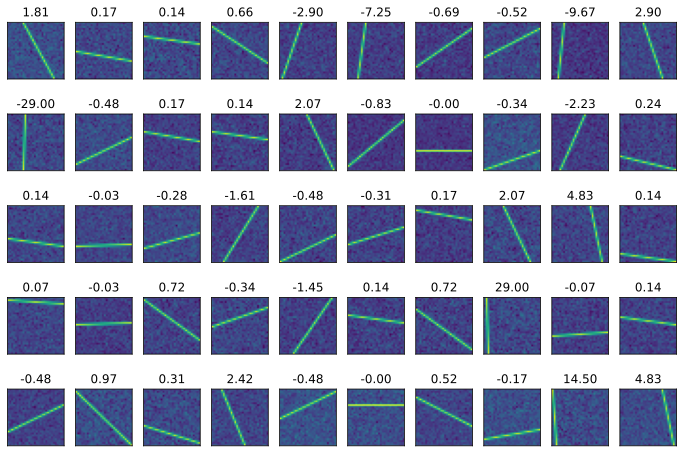

In [140]:
# visualize some images
fig,axs = plt.subplots(5,10,figsize=(12,8))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(nImages)
  G = np.squeeze( testimages[whichpic,:,:] )
  ax.imshow(G, origin='lower')
  ax.set_title(f'{slopes[whichpic].item():.2f}')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

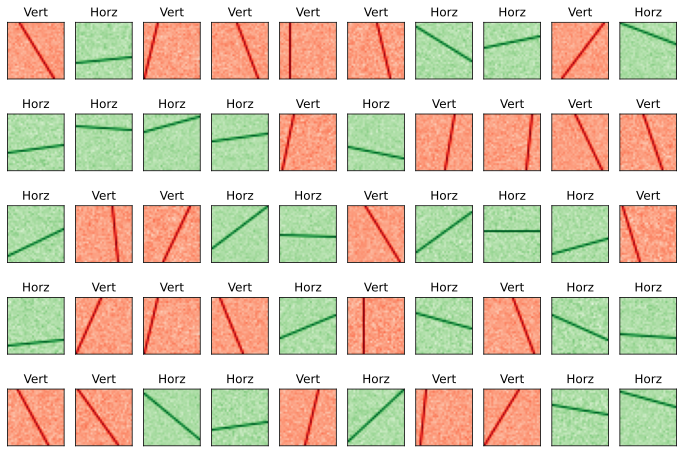

In [141]:
# run the test images
net.eval()
yHat = net(testimages)
yHat = torch.sigmoid(yHat).detach()

# visualize some images
fig,axs = plt.subplots(5,10,figsize=(12,8))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(nImages)
  G = np.squeeze( testimages[whichpic,:,:] )
  
  if yHat[whichpic].item() > .5:
    ax.imshow(G,vmin=-.5,vmax=1, cmap='Reds')
    ax.set_title("Vert" )
  else:
    ax.imshow(G,vmin=-.5,vmax=1, cmap='Greens')
    ax.set_title("Horz")  
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

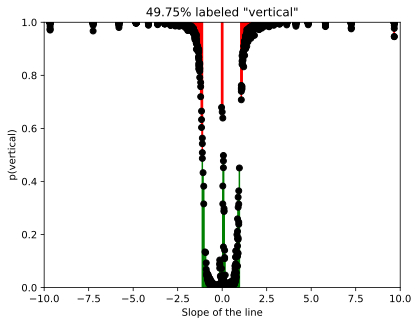

In [142]:
# plot the results (make sure the slopes use the same randomization)
for i in range(len(slopes)):
  xvals = [slopes[i].item(), slopes[i].item()]   
  if yHat[i]>.5:
    plt.plot(xvals,[1, yHat[i].item()],'r')    
  else:
    plt.plot(xvals,[0, yHat[i].item()],'g')

plt.plot(slopes,yHat,'ko')
plt.xlabel('Slope of the line')
plt.ylabel('p(vertical)')
plt.title('%.2f%% labeled "vertical"' %torch.mean(100*(yHat>.5).float()).item())
plt.ylim([0,1])
plt.xlim([-10,10]) # note: this actually clips two data points
plt.show()